# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

<h1> BISMILLAH SELESAI TEAM </h1>


* ATHRIYA GENFERIN

* LENKA MELINDA FLORIENKA


* SRI KRESNA MAHA DEWA

# Preparation

Import some library that will use in this practicum. There are several library and function below :

* Numpy for array operation
* Pandas as data manipulation
* Fetch_lfw_people is source of dataset

* Train_test_split for data splitting into train and test
* GridSearch is for hyperparameter tuning
* SVC is our base model, stand for Support Vector Classifier
* Then some metrices that will use to evaluate model, consist of confusion matrix, accuracy score and classification report

* Matplotlib and seaborn as visualisation library

* Principal Component Analysis is for dimentional reduction and also feature extraction to get minimum representation of a whole feature
* BestEstimator will be use for Class parameter, because we will implement streamline pipeline to preprocess and train so we need this library for our Preprocessing class
* TransformerMixin is standard library to provide capability to `fit_transform`and `transform` for custom Scikit-learn class
* Pipeline is a wrap of the preprocessing step into modeling step
* RobustScaler is powerful scaler from Scikit-learn to minimize outlier because the mechanism of scaler is use IQR base

* For the secondary model, we use Simple Multilayer Neural Network. So, in this case our team decided to use Tensorflow as library for deep learning training
* Sequential is use for creating neural network architecture in sequence form
* Dense is a perceptron in neural network architecture, the main thing that process the dataset into prediction.
* Eearly Stopping is callback that use for stop the training process if there are growth in the accuracy or model performance

* The last one is warnings, it used to remove every warnings output so it would be a clean output

In [26]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Load Data

Start to load dataset from online source using `fetch_lfw_people` method that has been imported before

In [27]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=100, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 5
Data dimension: (1140, 62, 47, 3)
Images flatten dimension: (1140, 8742)


Our dataset have n label or different person faces with 62x47 sized with RGB-channel. The dataset also contain flatten image in 1D vector.

Let's start to see what kind of people in our dataset, by plotting it

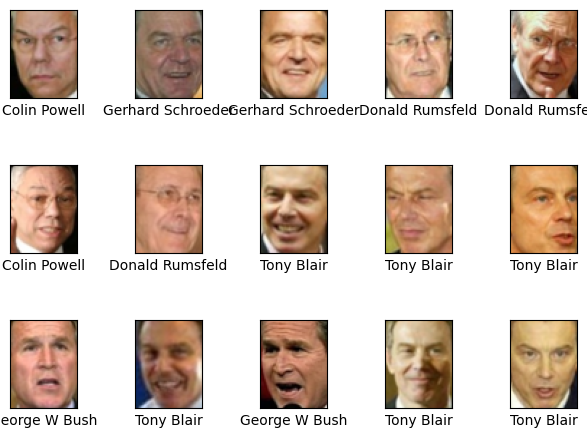

In [28]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

Check the dataset structure

In [29]:
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

Of course, we have 5 columns, let's check it more deeply about what the inside of each columns

In [30]:
print("----- Data")
print(faces.data[0])
print("----- Image")
print(faces.images[0])
print("----- Target")
print(faces.target[0])
print("----- Target Names")
print(faces.target_names[0])

----- Data
[0.36862746 0.34509805 0.24705882 ... 0.8352941  0.8117647  0.827451  ]
----- Image
[[[0.36862746 0.34509805 0.24705882]
  [0.4        0.36078432 0.28235295]
  [0.32941177 0.25882354 0.19215687]
  ...
  [0.4862745  0.43137255 0.3254902 ]
  [0.46666667 0.40784314 0.3019608 ]
  [0.42745098 0.36862746 0.25882354]]

 [[0.4        0.38039216 0.27058825]
  [0.45882353 0.40392157 0.31764707]
  [0.27450982 0.18039216 0.09411765]
  ...
  [0.5176471  0.4509804  0.34901962]
  [0.47843137 0.41960785 0.30980393]
  [0.44705883 0.38431373 0.27450982]]

 [[0.43529412 0.40392157 0.2901961 ]
  [0.4392157  0.35686275 0.2627451 ]
  [0.32156864 0.19215687 0.10196079]
  ...
  [0.41960785 0.34901962 0.23921569]
  [0.4745098  0.4117647  0.3019608 ]
  [0.44705883 0.3882353  0.28235295]]

 ...

 [[0.10980392 0.1254902  0.00784314]
  [0.13725491 0.13333334 0.01960784]
  [0.1764706  0.16862746 0.03137255]
  ...
  [0.5686275  0.36078432 0.25490198]
  [0.52156866 0.3529412  0.27058825]
  [0.5137255  0.39

From the dataset, we found that the dataset have some attribute like `data` is flatten image of face. `images` is image array. `target` is label of the images. `target_names` is name that reference with the target. `DESCR` is the description of the data

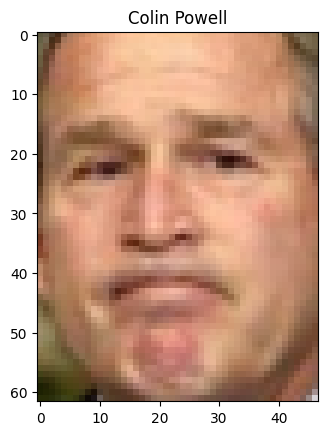

In [31]:
plt.imshow(faces.images[0])
plt.title(faces.target_names[0])
plt.show()

# EDA (Exploratory Data Analysis)

WE have some objective from the practicum. Let's make sure our dataset is meet the criteria :

* Have same size, (if don't, we need preprocess it later)
* Each Label have minimum 10 image (more is better)
* Each Image is RGB

In [32]:
def size_check(data):
    for i in range(len(data)):
        if data[i].shape != data[0].shape:
            print(f'Image {i} has different size')
            return False
    print('All images have same size')
    return True

def label_check(target, min_images=10):
    label_counts = np.bincount(target)
    for label, count in enumerate(label_counts):
        if count < min_images:
            print(f'Label {label} has less than {min_images} images: {count} images')
            return False
    print(f'All labels have at least {min_images} images')
    return True

def rgb_check(data):
    for i in range(len(data)):
        if data[i].shape[-1] != 3:
            print(f'Image {i} is not RGB')
            return False
    print('All images are RGB')
    return True

size_check(faces.images)
label_check(faces.target)
rgb_check(faces.images)
label = np.bincount(faces.target)
label.shape

All images have same size
All labels have at least 10 images
All images are RGB


(5,)

# Features Extraction

Let we start to create our feature extraction, because our team training method is streamlined pipeline. We need to change the example of Histogram Feature Extraction into Class. The `HistogramExtractor` class use `BaseEstimator` and `TransformerMixin` as parameter. The functionality of `BaseEstimator` and `TransformerMixin` comes from the scikit-learn library and is designed to make it easier to create custom estimators and transformers that are compatible with the scikit-learn ecosystem.

How The HistogramExtractor work on the images is like in this picture :

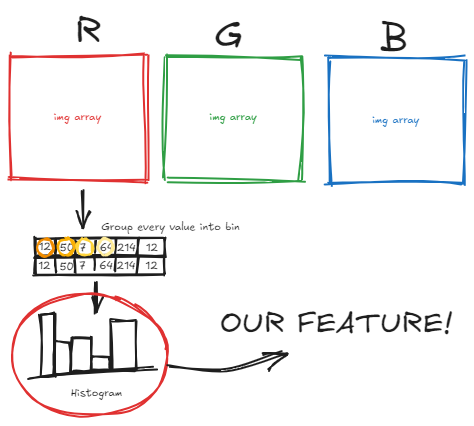


What about the Principle Component Analysis (PCA) did? PCA work as dimensionality reduction, where they will reducing feature dimensions while preserving as much information as possible by representing data in (principal components) space. Here the visualization :

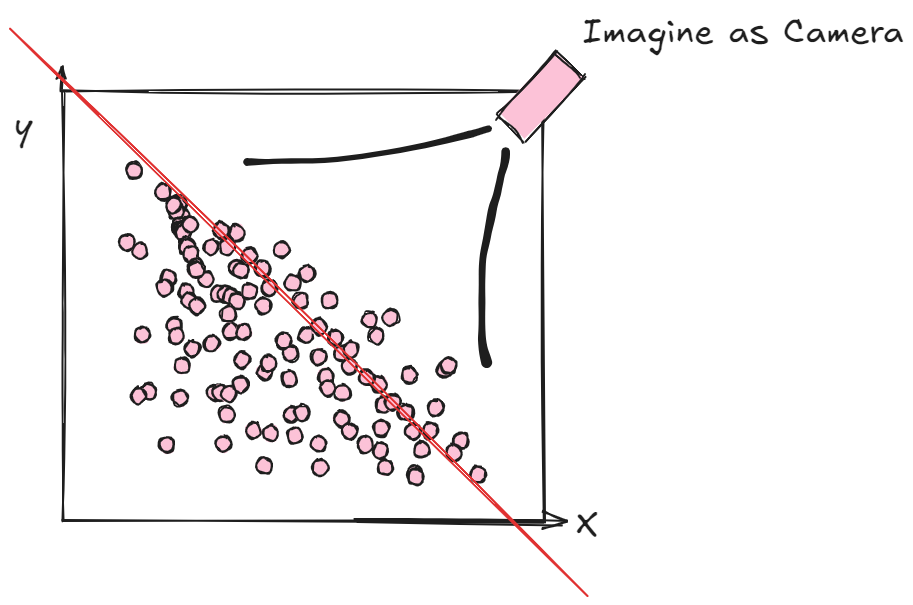

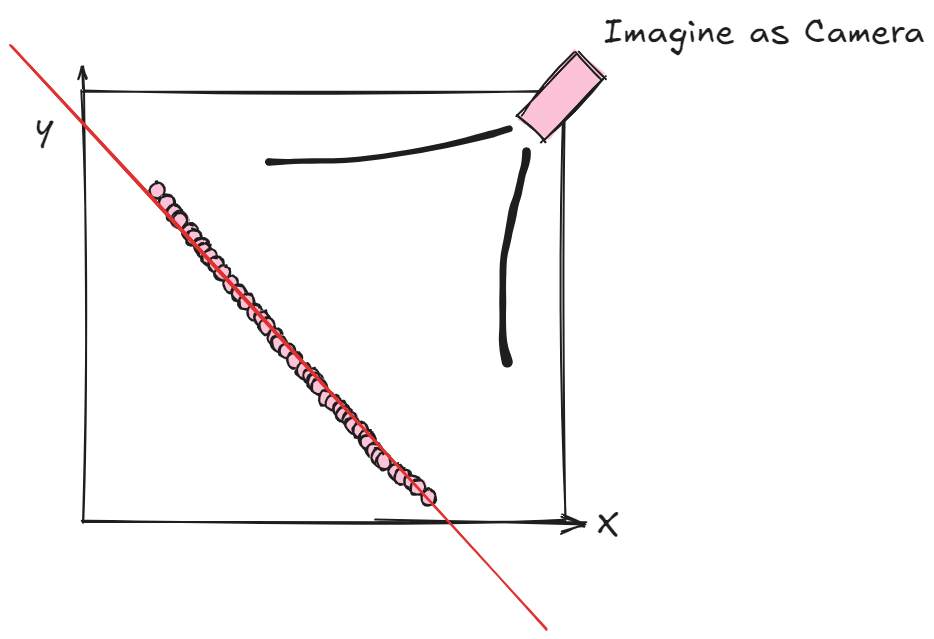

We don't write PCA algorithm from scratch before they have a lot math and statistics stuff. We will use scikit-learn library that provided PCA package that is ready to use

In [33]:
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''
class HistogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, bins_num=5):
        self.bins_num = bins_num

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        hist_data = []
        for i in X:
            h_red = np.histogram(i[..., 0].ravel(), bins=self.bins_num)[0]
            h_green = np.histogram(i[..., 1].ravel(), bins=self.bins_num)[0]
            h_blue = np.histogram(i[..., 2].ravel(), bins=self.bins_num)[0]
            h_concat = np.concatenate((h_red, h_green, h_blue), axis=0) # Concat in row basis
            hist_data.append(h_concat)
        return np.array(hist_data)

class PCAExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components, whiten=True)

    def fit(self, X, y=None):
        data_flatten = X.reshape((X.shape[0], -1))
        self.pca.fit(data_flatten)
        return self

    def transform(self, X):
        data_flatten = X.reshape((X.shape[0], -1))
        data_pca = self.pca.transform(data_flatten)
        return data_pca

# Build Model

AS I mention before, for our preprocessing step into modeling step will cover into a Pipeline. So it more clean and easy to use like modular things. The pipeline structure we have a Scaler-Feature Extractor-Algorithm. For the scaler our team decided to use `RobustScaler` because their capability to handle outlier, so we don't need to check and clear outlier separately. Why? because `RobustScaler` use IQR method that often we use as outlier filter. If we look at the `RobustScaler` formula we will understand :

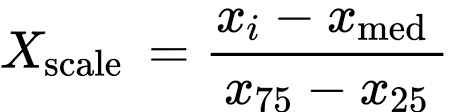

Then, the feature extraction part we will use both of `HistogramExtractor` and `PCAExractor` in the separately pipeline. So we will have 2 pipeline named `pipeline_hist` and `pipeline_pca`. The last one is algorithm, For both pipeline we use `Support Vector Classifier` or `SVC` as first model in this phase

`HistogramExtractor` take parameter `bins_num=50`. The result is a histogram feature vector with length 50 × 3 = 150 for each image (50 bins for each RGB channel). `PCAExtractor` take parameter `n_components=100` which mean PCA will keep 100 main component or features that contain majority information from a whole data

In [34]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''

pipeline_hist = Pipeline([
    ('scaler', RobustScaler()),
    ('histogram', HistogramExtractor(bins_num=50)),
    ('svc', SVC())
])

pipeline_pca = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCAExtractor(n_components=100)),
    ('svc', SVC())
])

Next, we just regularly split the data into training set and testing_set with ratio 80:20. 20% for testing_set. And also, we stratify the splitting to keep the proportion is balanced

In [35]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, random_state=123, stratify=faces.target)

In [36]:
X_train.shape

(912, 8742)

For our training schema, we will directly use `GridSearch` to find optimal model based on defined parameter. In this schema different with regular training that put the data directly into the model that use default parameters. `GridSearch` will trying fit the model with the best parameter, so the first step to start using this schema is define the parameters for the algorithm. Because our algorithm before is `SVC` so we will tune or give some parameters that will be try by `GridSearch` to find the best model from one of the parameters. 

`SVC` have a lot parameter, but in this case we will use `kernel`, `C`, and `gamma`

* `Kernel` is a function used by SVM to map data from the original feature space to a higher dimensional space

* `C` is a regulatory parameter that controls the trade-off between classification error in the training data and the maximum margin.

* `Gamma` determines how much influence an individual data point has on the results of the SVM model, especially for RBF and Polynomial kernels.

In [37]:
# Define parameter grid
params = {
    'svc__kernel': ['rbf', 'linear'],
    'svc__C': [0.1, 1],
    'svc__gamma': [0.1, 1]
}

After that, because we have 2 feature extraction technique that cannot use both in one times. SO we will create 2 `GridSearch` that use different feature extraction, and we will check where is better from both. Useful things in `GridSearch` is `cv` or `Cross Validation` so we don't need to did it manually, just use it and define how much you want to do

In [38]:
# Create GridSearchCV objects
grid_hist = GridSearchCV(pipeline_hist, params, cv=3, verbose=1, n_jobs=-1)
grid_pca = GridSearchCV(pipeline_pca, params, cv=3, verbose=1, n_jobs=-1)

All of is Ready. Fit the `GridSearch` into the training set

In [39]:
# Fit and evaluate the models

grid_hist.fit(X_train, y_train)
grid_pca.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('pca', PCAExtractor()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1], 'svc__gamma': [0.1, 1],
                         'svc__kernel': ['rbf', 'linear']},
             verbose=1)

After the fitting or training done. We can check where is params who result the best score, use attributes `best_params_` and `best_score_` to see it

In [40]:
# Print best parameters and scores
print("Best parameters for histogram pipeline:", grid_hist.best_params_)
print("Best score for histogram pipeline:", grid_hist.best_score_)

print("Best parameters for PCA pipeline:", grid_pca.best_params_)
print("Best score for PCA pipeline:", grid_pca.best_score_)

Best parameters for histogram pipeline: {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best score for histogram pipeline: 0.46491228070175444
Best parameters for PCA pipeline: {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Best score for PCA pipeline: 0.8300438596491229


# Evaluation

The last thing after training is evaluation the performance of our model. try to `predict` the testing set to get the result of our effort. Then, we can use `classification_report` to get brief information about the performance our model. From `classification_report` we will knows a bunch of things, like `Precision`, `Recall`, `F1-Score`, `Accuracy` and more

In [41]:
'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
    dengan menggunakan metric akurasi dan juga classfication report

    Hints:
        Anda dapat menggunakan referensi Jobseet 4 Percobaan 5
'''

# Evaluation
# Eval on Training

# Predict
y_pred_hist = grid_hist.predict(X_test)
y_pred_pca = grid_pca.predict(X_test)

# Evaluate
print("Classification report of histogram pipeline:")
print(classification_report(y_test, y_pred_hist))

print("Classification report of PCA pipeline:")
print(classification_report(y_test, y_pred_pca))

Classification report of histogram pipeline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.00      0.00      0.00        24
           2       0.46      1.00      0.63       106
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        29

    accuracy                           0.46       228
   macro avg       0.09      0.20      0.13       228
weighted avg       0.22      0.46      0.30       228

Classification report of PCA pipeline:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        47
           1       0.71      0.71      0.71        24
           2       0.90      0.84      0.87       106
           3       0.80      0.91      0.85        22
           4       0.84      0.72      0.78        29

    accuracy                           0.84       228
   macro avg       0.81      0.82      0.81    

To get more deep evaluation we can look at the confusion matrix, from the confusion matrix we can knows about where the model correct in predicting or not. And also from confusion matrix we will get the derivative matrices like `precision`, `recall` and more. To improve the usability, We create a method called `plot_confusion_matrix_top_n` so if we need to visualize it, we just use this method

In [57]:
# Confusion matrix
def plot_confusion_matrix_top_n(y_true, y_pred, labels, top_n=5, title=""):
    # Get the most common labels
    unique_labels, counts = np.unique(y_true, return_counts=True)
    top_labels = unique_labels[np.argsort(counts)[-top_n:]]

    # Filter the confusion matrix for top labels
    cm = confusion_matrix(y_true, y_pred, labels=top_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_labels, yticklabels=top_labels)
    plt.title(f'Confusion Matrix {title} for Top {top_n} Labels')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Visualize the confusion matrix from model with feature extraction histogram and SVM as model

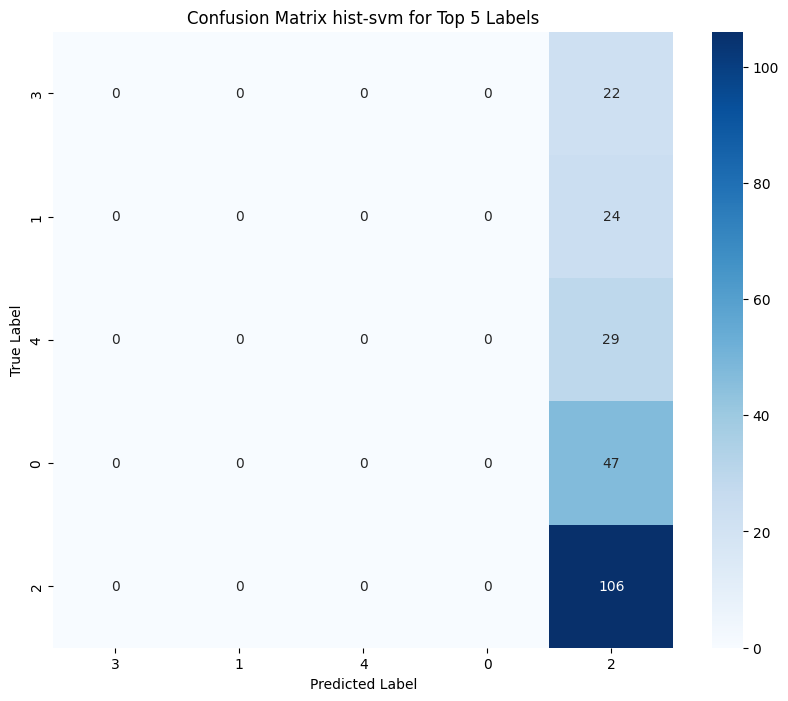

In [58]:
plot_confusion_matrix_top_n(y_test, y_pred_hist, faces.target_names, title="hist-svm")

Visualize the confusion matrix from model with feature extraction PCA and SVM as model

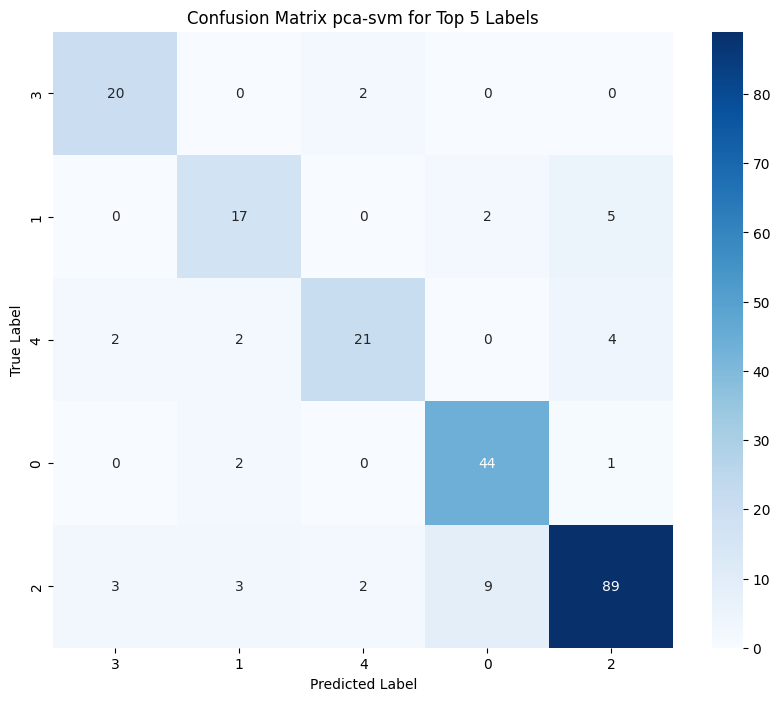

In [59]:
plot_confusion_matrix_top_n(y_test, y_pred_pca, faces.target_names, title="pca-svm")

# ANOTHER MODEL

What about another model? will they give same result? or better result or probably a worse ? Let's check this out

## Logistic Regression

Firstly, we will try the simple model called `LogisticRegression`, the name is regression but this is not for regression case. The `Logistic Regression` will classify the data use `sigmoid` function. Look at the picture to the better explaination.

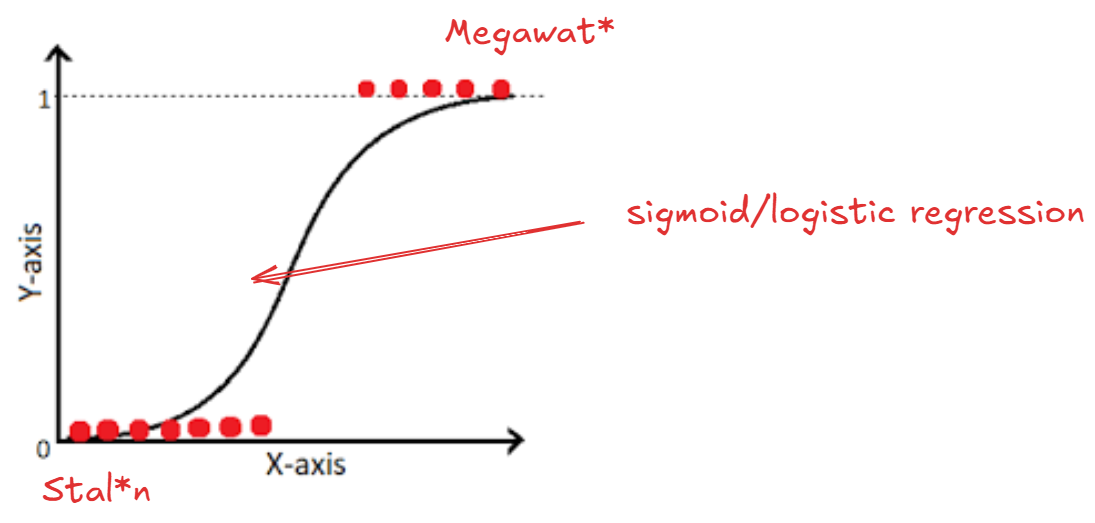

If you wondering about `max_iter` is used for defined how much model can be iterated until they meet the convergence, this happen because `Logistic Regression` use optimization method like `gradient_descent`

And also if you didn't realize that our team fit the model directly into training set, not through preprocessing first and feature extraction because we want to know how the model performance without these things.

In [76]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(
    random_state=123,
    max_iter=10000
)

lg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=123)

Evaluate the model with `classification_report` and confusion matrix  

In [77]:
y_pred_lg = lg.predict(X_test)
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        47
           1       0.78      0.88      0.82        24
           2       0.97      0.92      0.94       106
           3       0.95      0.95      0.95        22
           4       0.96      0.93      0.95        29

    accuracy                           0.93       228
   macro avg       0.91      0.93      0.92       228
weighted avg       0.93      0.93      0.93       228



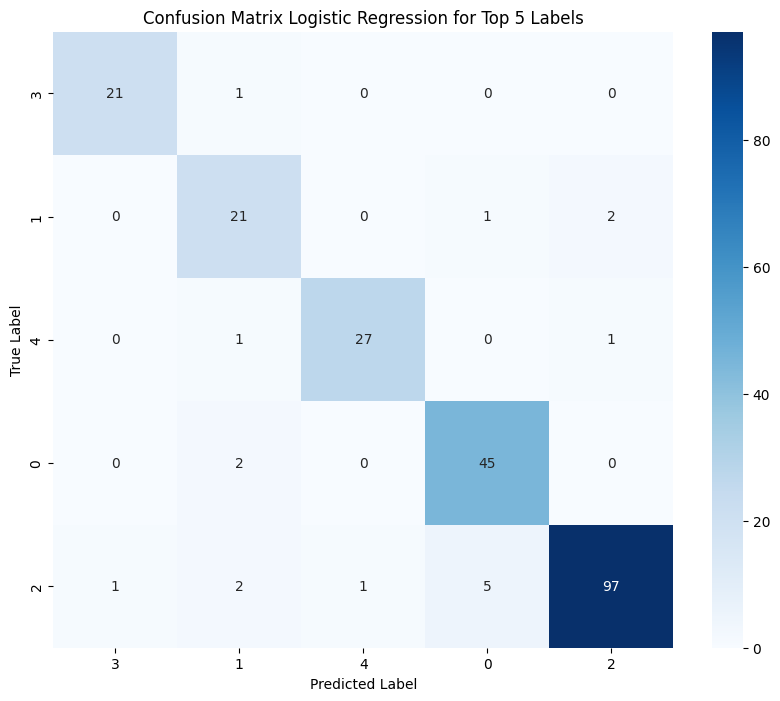

In [94]:
plot_confusion_matrix_top_n(y_test, y_pred_lg, faces.target_names, title="Logistic Regression")

The result is much better, `Logistic Regression` give 93% accuracy in this case

## Random Forest

After we done with simple model, let's  try with a bit complicated model in classic machine learning algorithm that is `Random Forest`. Just look at the picture to get understanding about the model :D

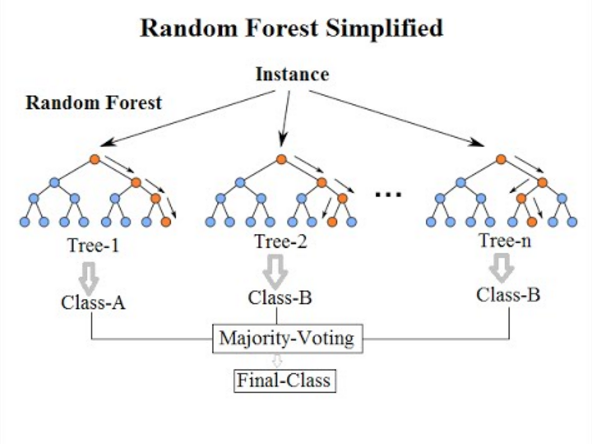

`Random Forest` combine some of tree to classify the data then choose where is the highest performance.

In [78]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=123
)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

Evaluate the model with classification report and confusion matrix 

In [80]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        47
           1       1.00      0.21      0.34        24
           2       0.66      0.99      0.79       106
           3       1.00      0.05      0.09        22
           4       0.81      0.45      0.58        29

    accuracy                           0.72       228
   macro avg       0.87      0.51      0.53       228
weighted avg       0.79      0.72      0.67       228



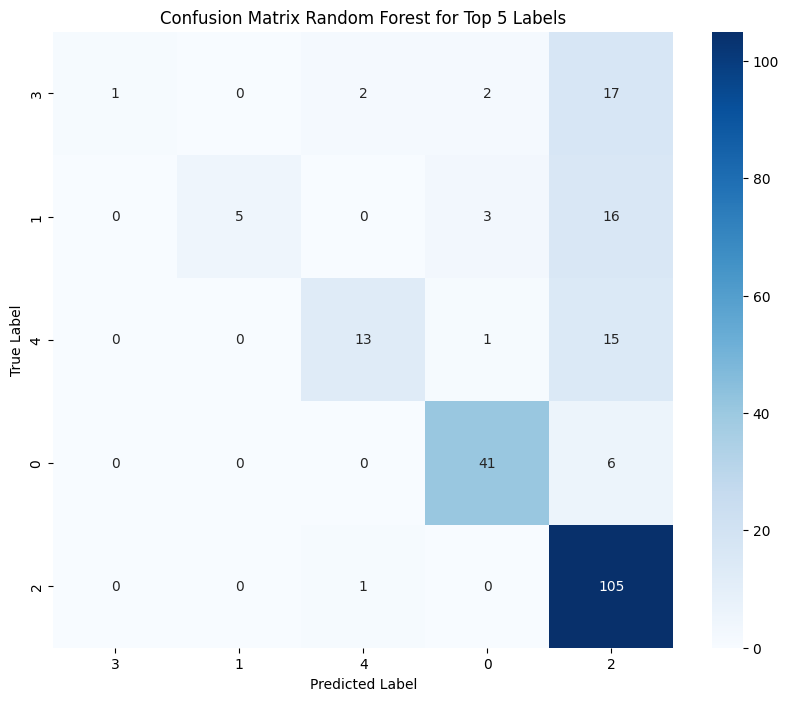

In [95]:
plot_confusion_matrix_top_n(y_test, y_pred_rf, faces.target_names, title="Random Forest")

The result is not better than `Logistic Regression`, it just result 72% in `accuracy`. Maybe this data not good enough with complicated algorithm? Fifty-fifty!

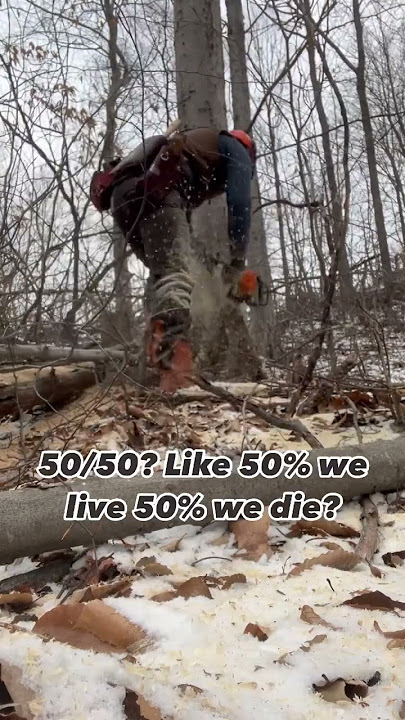

## Stacking Model

Bam! What if we combine all of model that has been we use before into the one model? Let's try! To combine some model, `scikit-learn` provided us with `StackingClassifier` that give us capability to stack a bunch model into one. The mechanism is fit the data with some model then push it into the final model to get final result. This also have `cv` or `Cross Validation` so powerful

In [81]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lg', LogisticRegression(random_state=123, max_iter=10000)),
    ('rf', RandomForestClassifier(random_state=123)),
    ('svc', SVC())
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

stack.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('lg',
                                LogisticRegression(max_iter=10000,
                                                   random_state=123)),
                               ('rf', RandomForestClassifier(random_state=123)),
                               ('svc', SVC())],
                   final_estimator=LogisticRegression())

Evaluate the model with classification report and confusion matrix

In [82]:
y_pred_stack = stack.predict(X_test)
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        47
           1       0.81      0.88      0.84        24
           2       0.96      0.91      0.93       106
           3       0.91      0.91      0.91        22
           4       0.93      0.93      0.93        29

    accuracy                           0.92       228
   macro avg       0.90      0.92      0.91       228
weighted avg       0.92      0.92      0.92       228



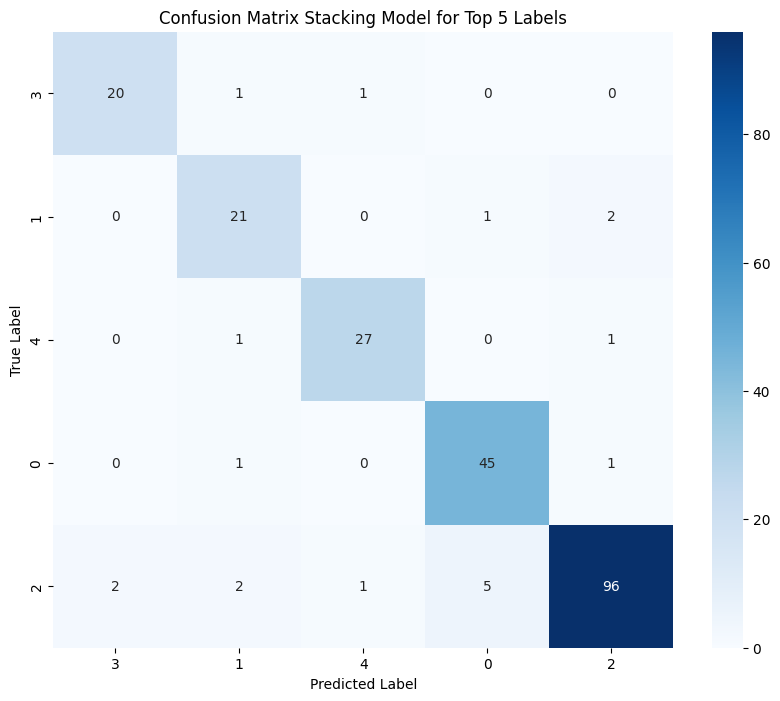

In [96]:
plot_confusion_matrix_top_n(y_test, y_pred_stack, faces.target_names, title="Stacking Model")

## Simple Multi Layer Neural Network

WE has been try the classic machine learning algorithm, what if we use semi-modern machine learning? Yeps it's called deep learning. In this time, we will use a simple multi layer neural network to test how the model performance compared to classical machine learning. Multi layer neural network consist of `Dense` or Perceptron that imitate the how human brain work. Mathematically, this Dense use a linear formula with a little addition that is `activation_function`. Activation Function have a function to do non-linearity, why? because most of the time, when we use neural network is to deal with non-linearity problem. What is we use linear function inside neural network? It just result a BOURJOIS-linear regression because need a big computation to compute this architecture. 

To create multi layer neural network have some kind of way, but to keep simplity and fast. We use `Sequential` way and again, it already provided by `Tensorflow` library. After that, stack the `Dense` to create multi layer schema. The `activation_function` we will use `relu` where they have a good capability to reduce the `deminishing gradient` we don't talk about it in this practice. For the last layer we use `softmax` as `activation_function` and 5 Dense, in this last layer need some attention, firstly amount of Dense is reference to amount of label/target and `activation_function` refer to method that classify the data. `softmax` will compute probability of input base on the label. So far, our architecture is like this :

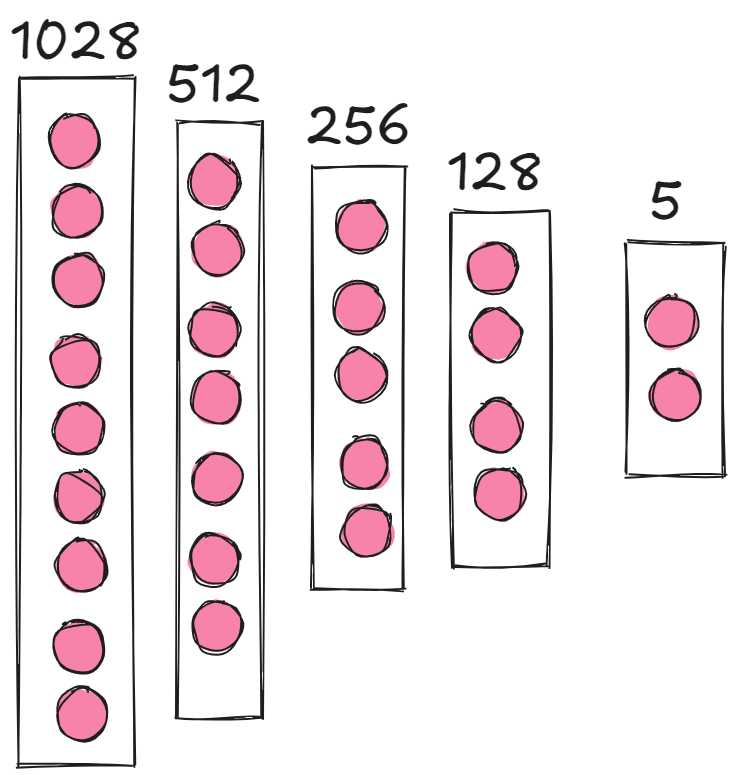

If the architecture of model is clear, let's move to compile the model. In the method `compile` there are some parameter like `optimizer`, `loss` and `metrics`. Simple `optimizer` is use by the model to get the lowest `global minima` in `gradient descent`. Why we have talk about Gradient many times? Because model like linear regression, logistic, and neural network have to search the minimum loss/error and this concept called `gradient descent`. So, we back to the `optimizer`, choosing right `optimizer` is important, mostly in `adam` or `Adaptive Momentum` is widely use for training the model and there are many improvement and variant of `adam`.

Then we have `loss`, this is a parameter that calculate the loss/error from the model. In our case is classification multiclass so we can use `sparse_categorical_crossentropy`. Our standard `metrices` for our training is `accuracy`

The last one before fit the model, we have `callback` called `early_stopping`, this callback will stop the training while the performance of model (in this case we monitor `validation_loss`) with threshold stagnant is 3. When model not improve in 4 iterate the training will be stopped

Then, we can start to fit or training the model. In this line of code, we found new words again that's is `epoch`. `Epoch` refer how much we train the model.

In [90]:
model = Sequential([
    Dense(1028, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])



Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 473ms/step - accuracy: 0.3552 - loss: 3.8186 - val_accuracy: 0.4426 - val_loss: 1.8950
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4643 - loss: 1.5803 - val_accuracy: 0.4426 - val_loss: 1.4992
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4409 - loss: 1.4341 - val_accuracy: 0.5519 - val_loss: 1.3451
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5103 - loss: 1.4129 - val_accuracy: 0.4098 - val_loss: 1.4720
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5630 - loss: 1.2584 - val_accuracy: 0.5628 - val_loss: 1.1542
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5849 - loss: 1.1154 - val_accuracy: 0.5410 - val_loss: 1.0439
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6195 - loss: 1.0296 - val_accuracy: 0.5956 - val_loss: 0.9822
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6469 - loss: 0.8925 - val_accuracy: 0.5301 - val_l

After the training is finish, evaluate the model with classification report and confusion matrix. One different things when we start to predict using the deep learning model. Before the output layers is using softmax that calculated the probability of the label/target. Then, to generate this in evaluation or inference we use method `argmax` to get exact value of prediction.

In [91]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

y_pred_dl = model.predict(X_test)
y_pred_dl = np.argmax(y_pred_dl, axis=1)

print("Classification report of Deep Learning model:")
print(classification_report(y_test, y_pred_dl))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7375 - loss: 0.6748
Accuracy: 0.7324561476707458
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classification report of Deep Learning model:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83        47
           1       0.69      0.92      0.79        24
           2       0.91      0.82      0.86       106
           3       0.34      0.91      0.49        22
           4       0.75      0.10      0.18        29

    accuracy                           0.73       228
   macro avg       0.73      0.70      0.63       228
weighted avg       0.82      0.73      0.73       228



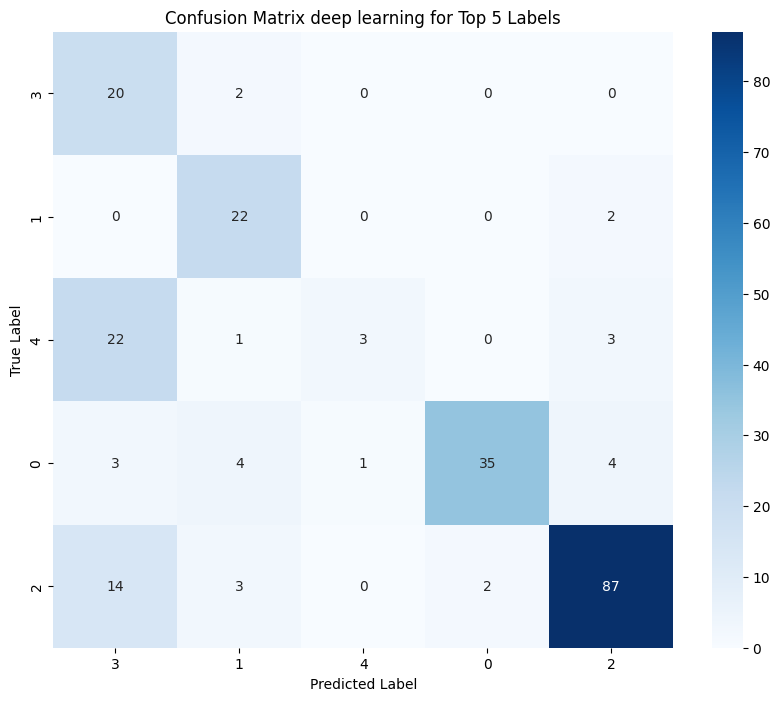

In [92]:
plot_confusion_matrix_top_n(y_test, y_pred_dl, faces.target_names, title="deep learning")

Multi layer neural network get 73% in accuracy. It's not good enough compared to a simple model logistic regression or support vectore machine. 

# Conclusion

SUMMARY of PRACTICE :

* Histogram Extractor + SVM = 46% accuracy
* PCA Extractor + SVM = 84% accuracy
* Logistic Regression = 93% accuracy
* Random Forest = 72% accuracy
* Stacking Classifier = 92% accuracy
* Simple Multi-layer Neural Network = 73% accuracy


From benchmark above, we can conclude that the dataset have a good result with Simple Algorithm like **SVM with PCA, Logistic Regression**. When the data trained with complex model like **Random Forest, Neural Network**. But the simple algorithm didn't always give a better result compared with complex model, it's proven on **SVM with Histogram**.